In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
from itertools import combinations
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from tqdm import tqdm

pd.set_option('mode.chained_assignment', None)

tqdm.pandas()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [60]:
data_fp = 'data/'
fake_fp = data_fp + 'df_preprocessed_fake.csv'
true_fp = data_fp + 'df_preprocessed_real.csv'

fake_df = pd.read_csv(fake_fp)
true_df = pd.read_csv(true_fp)

In [61]:
df = pd.concat([fake_df, true_df])

# IMPORTANT FOR ACCURACY: Remove duplicate rows!
df = df.drop_duplicates(subset=['combined']).reset_index().drop(columns=['Unnamed: 0', 'index'])
df.tail()

title  \
38905  north korea shipments to syria chemical arms a...   
38906  lexisnexis withdrew two products from chinese ...   
38907  minsk cultural hub becomes haven from authorities   
38908  vatican upbeat on possibility of pope francis ...   
38909     indonesia to buy billion worth of russian jets   

                                                    text              date  \
38905   two north korean shipments to syrian governme...  August 21, 2017    
38906   lexisnexis provider of legal regulatory and b...  August 22, 2017    
38907   in the shadow of disused sovietera factories ...  August 22, 2017    
38908   vatican secretary of state cardinal pietro pa...  August 22, 2017    
38909   indonesia will buy sukhoi fighter jets worth ...  August 22, 2017    

       fake  text_sentences  \
38905     0              29   
38906     0               7   
38907     0              17   
38908     0              10   
38909     0              13   

                                                combined  title_chars  \
38905  north korea shipments to syria chemical arms a...           73   
38906  lexisnexis withdrew two products from chinese ...           52   
38907  minsk cultural hub becomes haven from authorit...           49   
38908  vatican upbeat on possibility of pope francis ...           61   
38909  indonesia to buy billion worth of russian jets...           46   

       text_chars  title_words  text_words  text_avg_word_length  \
38905        2761           11         432              6.391204   
38906         747            7         119              6.277311   
38907        1823            7         298              6.117450   
38908        1135            9         195              5.820513   
38909        1255            8         196              6.403061   

       text_avg_sent_length  \
38905             14.896552   
38906             17.000000   
38907             17.529412   
38908             19.500000   
38909             15.076923   

                                          combined_no_sw  \
38905  north korea shipments syria chemical arms agen...   
38906  lexisnexis withdrew products chinese market le...   
38907  minsk cultural hub haven authorities shadow di...   
38908  vatican upbeat possibility pope francis visiti...   
38909  indonesia buy billion worth russian jets indon...   

                                        combined_no_skew  sentiment  \
38905  north korea shipments syria chemical arms agen...  -0.042119   
38906  lexisnexis withdrew products chinese market le...   0.020000   
38907  minsk cultural hub haven authorities shadow di...   0.056011   
38908  vatican upbeat possibility pope francis visiti...   0.021993   
38909  indonesia buy billion worth russian jets indon...   0.035606   

                                       combined_no_names  
38905  shipments chemical arms agency intercepted rep...  
38906  withdrew products chinese market provider lega...  
38907  cultural hub haven authorities shadow disused ...  
38908  upbeat possibility visiting secretary cardinal...  
38909  buy billion worth russian jets buy fighter jet...

In [31]:
def split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)


def remove_correlated_features(X):
    correlated_features = set()

    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                col = corr_matrix.columns[i]
                correlated_features.add(col)

    cols = [n for n in num_cols if n not in correlated_features]
    return X


def recursive_feature_eliminate(estimator, X_train, y_train, param_grid, est_name):
    # Keep splits and repeats low to save time; doesn't change features selected
    cv = RepeatedStratifiedKFold(
        n_splits=2, n_repeats=1, random_state=1)
    rfecv = RFECV(estimator, step=1, cv=cv, scoring='accuracy').fit(X_train, y_train)
    clf = RandomizedSearchCV(rfecv, param_grid, cv=cv, verbose=10)
    pipeline = make_pipeline(StandardScaler(), clf)
    pipeline.fit(X_train, y_train)
    
    est_eval = pd.Series([], dtype=np.float64)
    est_eval.loc['est_name'] = est_name
    est_eval.loc['best_est'] = clf.best_estimator_.estimator_
    est_eval.loc['best_params'] = clf.best_params_
    est_eval.loc['best_score'] = round(clf.best_score_, 4)
    est_eval.loc['optimal_num_features'] = rfecv.n_features_
    
    X_train.drop(X_train.columns[
        np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
    
    est_eval.loc['new_features'] = list(X_train.columns)
    
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), 
             rfecv.grid_scores_, color='royalblue', linewidth=3)
    plt.title(f'Recursive Feature Elimination with Cross-Validation - {est_name}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Number of Features Selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification (Train)', fontsize=12, labelpad=20)
    plt.show()
    
    return pd.DataFrame(est_eval).T

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START estimator__C=1.0, estimator__penalty=l2, estimator__solver=liblinear
[CV 1/2; 1/10] END estimator__C=1.0, estimator__penalty=l2, estimator__solver=liblinear; total time=   0.4s
[CV 2/2; 1/10] START estimator__C=1.0, estimator__penalty=l2, estimator__solver=liblinear
[CV 2/2; 1/10] END estimator__C=1.0, estimator__penalty=l2, estimator__solver=liblinear; total time=   0.4s
[CV 1/2; 2/10] START estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs
[CV 1/2; 2/10] END estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs; total time=   0.3s
[CV 2/2; 2/10] START estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs
[CV 2/2; 2/10] END estimator__C=0.01, estimator__penalty=l2, estimator__solver=lbfgs; total time=   0.3s
[CV 1/2; 3/10] START estimator__C=0.01, estimator__penalty=l2, estimator__solver=newton-cg
[CV 1/2; 3/10] END estimator__C=0.01, estimator__penalty=l2, estimat

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START estimator__alpha=0.1.......................................
[CV 1/2; 1/10] END .....................estimator__alpha=0.1; total time=   0.1s
[CV 2/2; 1/10] START estimator__alpha=0.1.......................................
[CV 2/2; 1/10] END .....................estimator__alpha=0.1; total time=   0.1s
[CV 1/2; 2/10] START estimator__alpha=0.2.......................................
[CV 1/2; 2/10] END .....................estimator__alpha=0.2; total time=   0.1s
[CV 2/2; 2/10] START estimator__alpha=0.2.......................................
[CV 2/2; 2/10] END .....................estimator__alpha=0.2; total time=   0.1s
[CV 1/2; 3/10] START estimator__alpha=0.30000000000000004.......................
[CV 1/2; 3/10] END .....estimator__alpha=0.30000000000000004; total time=   0.1s
[CV 2/2; 3/10] START estimator__alpha=0.30000000000000004.......................
[CV 2/2; 3/10] END .....estimator__alpha=0.30000

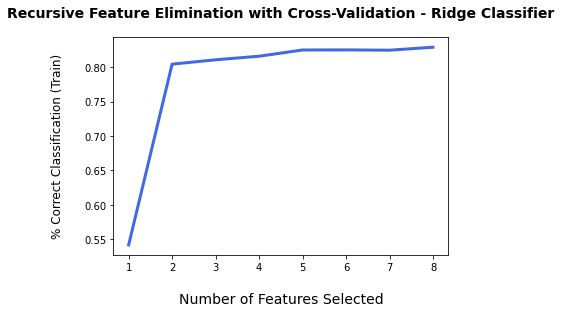

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2; 1/5] START estimator__C=50.............................................
[CV 1/2; 1/5] END ...........................estimator__C=50; total time=   0.4s
[CV 2/2; 1/5] START estimator__C=50.............................................
[CV 2/2; 1/5] END ...........................estimator__C=50; total time=   0.3s
[CV 1/2; 2/5] START estimator__C=10.............................................
[CV 1/2; 2/5] END ...........................estimator__C=10; total time=   0.3s
[CV 2/2; 2/5] START estimator__C=10.............................................
[CV 2/2; 2/5] END ...........................estimator__C=10; total time=   0.3s
[CV 1/2; 3/5] START estimator__C=1.0............................................
[CV 1/2; 3/5] END ..........................estimator__C=1.0; total time=   0.3s
[CV 2/2; 3/5] START estimator__C=1.0............................................
[CV 2/2; 3/5] END ..........................estim

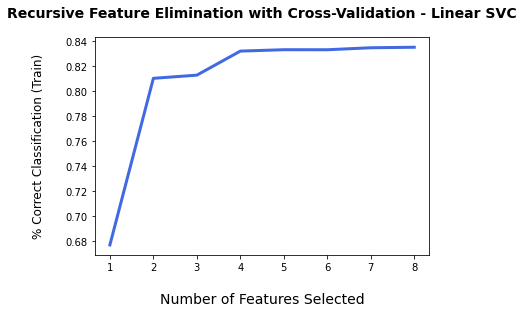

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=10....
[CV 1/2; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=10; total time=   3.0s
[CV 2/2; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=10....
[CV 2/2; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=10; total time=   3.1s
[CV 1/2; 2/6] START estimator__max_features=sqrt, estimator__n_estimators=20....
[CV 1/2; 2/6] END estimator__max_features=sqrt, estimator__n_estimators=20; total time=   6.0s
[CV 2/2; 2/6] START estimator__max_features=sqrt, estimator__n_estimators=20....
[CV 2/2; 2/6] END estimator__max_features=sqrt, estimator__n_estimators=20; total time=   6.2s
[CV 1/2; 3/6] START estimator__max_features=sqrt, estimator__n_estimators=40....
[CV 1/2; 3/6] END estimator__max_features=sqrt, estimator__n_estimators=40; total time=  11.1s
[CV 2/2; 3/6] START estimator__max_features=sqrt, estimator_

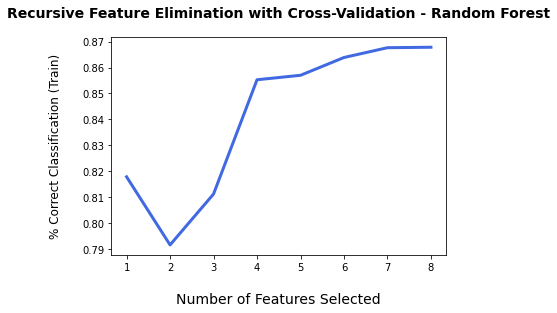

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START estimator__learning_rate=0.001, estimator__max_depth=9, estimator__n_estimators=40, estimator__subsample=1.0
[CV 1/2; 1/10] END estimator__learning_rate=0.001, estimator__max_depth=9, estimator__n_estimators=40, estimator__subsample=1.0; total time=  42.8s
[CV 2/2; 1/10] START estimator__learning_rate=0.001, estimator__max_depth=9, estimator__n_estimators=40, estimator__subsample=1.0
[CV 2/2; 1/10] END estimator__learning_rate=0.001, estimator__max_depth=9, estimator__n_estimators=40, estimator__subsample=1.0; total time=  38.5s
[CV 1/2; 2/10] START estimator__learning_rate=0.1, estimator__max_depth=9, estimator__n_estimators=40, estimator__subsample=0.7
[CV 1/2; 2/10] END estimator__learning_rate=0.1, estimator__max_depth=9, estimator__n_estimators=40, estimator__subsample=0.7; total time=  25.1s
[CV 2/2; 2/10] START estimator__learning_rate=0.1, estimator__max_depth=9, estimator__n_estimators=40, estima

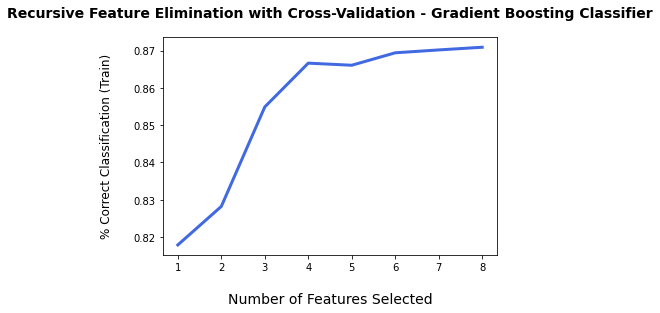

In [32]:
num_cols = ['text_sentences', 'title_chars', 'text_chars', 
            'title_words', 'text_words', 'text_avg_word_length', 
            'text_avg_sent_length', 'sentiment']


# ---LOGISTIC REGRESSION--- #
lr = LogisticRegression(max_iter=1000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
lr_c_vals = [100, 10, 1.0, 0.1, 0.01]
lr_param_grid = dict(estimator__solver=solvers, 
                     estimator__penalty=penalty,
                     estimator__C=lr_c_vals)

# ---RIDGE CLASSIFIER--- #
ridge = RidgeClassifier()
alpha = list(np.arange(0.1, 1.1, 0.1))
ridge_param_grid = dict(estimator__alpha=alpha)

# ---KNN CLASSIFIER--- #
knn = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
knn_param_grid = dict(estimator__n_neighbors=n_neighbors, 
                      estimator__weights=weights, 
                      estimator__metric=metric)

# ---LINEAR SVC CLASSIFIER--- #
svc = LinearSVC(dual=False)
svc_c_vals = [50, 10, 1.0, 0.1, 0.01]
svc_param_grid = dict(estimator__C=svc_c_vals)

# ---BAGGING CLASSIFIER--- #
bagging = BaggingClassifier()
bag_n_estimators = [10, 20, 40]
bagging_param_grid = dict(estimator__n_estimators=bag_n_estimators)

# ---RANDOM FOREST CLASSIFIER--- #
rf = RandomForestClassifier()
rf_n_estimators = [10, 20, 40]
rf_max_features = ['sqrt', 'log2']
rf_param_grid = dict(estimator__n_estimators=rf_n_estimators, 
                     estimator__max_features=rf_max_features)

# ---GRADIENT BOOSTING CLASSIFIER--- #
gb = GradientBoostingClassifier()
gb_n_estimators = [10, 20, 40]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
gb_param_grid = dict(estimator__n_estimators=gb_n_estimators, 
                     estimator__learning_rate=learning_rate, 
                     estimator__subsample=subsample,
                     estimator__max_depth=max_depth)

rfecv_hyper_df = pd.DataFrame()

# Random Forest wins here...
r_estimators = [lr, ridge, svc, rf, gb]
r_grids = [lr_param_grid, ridge_param_grid, svc_param_grid, rf_param_grid, gb_param_grid]
r_names = ['Logistic Regression', 'Ridge Classifier',
         'Linear SVC', 'Random Forest', 'Gradient Boosting Classifier']

X = df[num_cols]
y = df['fake']
X = remove_correlated_features(X)
X_train, X_test, y_train, y_test = split(X, y)
train_indicies, test_indices = X_train.index, X_test.index

for e, g, n in zip(r_estimators, r_grids, r_names):
    tmp = recursive_feature_eliminate(e, df[num_cols], df['fake'], g, n)
    rfecv_hyper_df = rfecv_hyper_df.append(tmp)

In [33]:
rfecv_hyper_df = rfecv_hyper_df.sort_values(by='best_score', ascending=False).reset_index().drop(columns=['index'])
rfecv_hyper_df

est_name  \
0  Gradient Boosting Classifier   
1                 Random Forest   
2           Logistic Regression   
3                    Linear SVC   
4              Ridge Classifier   

                                            best_est  \
0  ([DecisionTreeRegressor(criterion='friedman_ms...   
1  (DecisionTreeClassifier(max_features='sqrt', r...   
2  LogisticRegression(C=10, max_iter=1000, solver...   
3                       LinearSVC(C=0.1, dual=False)   
4                         RidgeClassifier(alpha=0.2)   

                                         best_params best_score  \
0  {'estimator__subsample': 0.5, 'estimator__n_es...     0.8705   
1  {'estimator__n_estimators': 40, 'estimator__ma...     0.8676   
2  {'estimator__solver': 'liblinear', 'estimator_...     0.8363   
3                              {'estimator__C': 0.1}     0.8352   
4                          {'estimator__alpha': 0.2}     0.8291   

  optimal_num_features                                       new_features  
0                    8  [text_sentences, title_chars, text_chars, titl...  
1                    8  [text_sentences, title_chars, text_chars, titl...  
2                    8  [text_sentences, title_chars, text_chars, titl...  
3                    8  [text_sentences, title_chars, text_chars, titl...  
4                    8  [text_sentences, title_chars, text_chars, titl...

In [34]:
rfecv_hyper_df['best_params'][0]

{'estimator__subsample': 0.5,
 'estimator__n_estimators': 40,
 'estimator__max_depth': 7,
 'estimator__learning_rate': 0.1}

In [35]:
rfecv_hyper_df['best_params'][1]

{'estimator__n_estimators': 40, 'estimator__max_features': 'sqrt'}

In [36]:
best_numerical_features = rfecv_hyper_df[
    rfecv_hyper_df['best_score'] == rfecv_hyper_df['best_score'].max()]['new_features'][0]
best_numerical_features

['text_sentences',
 'title_chars',
 'text_chars',
 'title_words',
 'text_words',
 'text_avg_word_length',
 'text_avg_sent_length',
 'sentiment']

In [39]:
model_hypers = pd.DataFrame()

# ---RANDOM FOREST CLASSIFIER FOR MODELING--- #
rf_model = RandomForestClassifier()
rf_model_n_estimators = [100, 200, 300]
rf_model_max_features = ['sqrt', 'log2']
rf_model_param_grid = dict(estimator__n_estimators=rf_model_n_estimators, 
                           estimator__max_features=rf_model_max_features)

# ---GRADIENT BOOSTING CLASSIFIER FOR MODELING--- #
gb_model = GradientBoostingClassifier()
gb_model_n_estimators = [10, 20, 30, 40, 50, 60]
gb_model_learning_rate = [0.001, 0.01, 0.1]
gb_model_subsample = [0.5, 0.7, 1.0]
gb_model_max_depth = [3, 7, 9]
gb_model_param_grid = dict(estimator__n_estimators=gb_model_n_estimators, 
                     estimator__learning_rate=gb_model_learning_rate, 
                     estimator__subsample=gb_model_subsample,
                     estimator__max_depth=gb_model_max_depth)

def model_hyperparams(X_train, X_test, y_train, y_test, estimator, param_grid, estimator_name):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    pipe = Pipeline(steps=[('standardize', StandardScaler()), ('estimator', estimator)])
    sh = RandomizedSearchCV(pipe, param_grid, cv=cv, verbose=10)
    sh.fit(X_train[best_numerical_features], y_train)
    
    results = pd.Series([], dtype=np.float64)
    results.loc['estimator_name'] = estimator_name
    results.loc['best_params'] = sh.best_params_
    results.loc['best_training_score'] = round(sh.best_score_, 4)
    results.loc['best_params_test_score'] = round(sh.score(X_test, y_test), 4)
    
    return pd.DataFrame(results).T


model_estimators = [rf_model, gb_model]
model_grids = [rf_model_param_grid, gb_model_param_grid]
model_names = ['Random Forest', 'Gradient Boosting Classifier']

for e, g, n in zip(model_estimators, model_grids, model_names):
    print(f'Training {n}')
    model_hypers = model_hypers.append(model_hyperparams(X_train, X_test, y_train, y_test, e, g, n))
    
model_hypers.sort_values(by='best_params_test_score')

Training Random Forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=100...


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=100; total time=   3.5s
[CV 2/5; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=100...
[CV 2/5; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=100; total time=   3.4s
[CV 3/5; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=100...
[CV 3/5; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=100; total time=   3.5s
[CV 4/5; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=100...
[CV 4/5; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=100; total time=   3.7s
[CV 5/5; 1/6] START estimator__max_features=sqrt, estimator__n_estimators=100...
[CV 5/5; 1/6] END estimator__max_features=sqrt, estimator__n_estimators=100; total time=   3.8s
[CV 1/5; 2/6] START estimator__max_features=sqrt, estimator__n_estimators=200...
[CV 1/5; 2/6] END estimator__max_features=sqrt, estimator__n_estimators=200; total time=   7.7s
[CV 2/5; 2/6] START

estimator_name  \
0                 Random Forest   
0  Gradient Boosting Classifier   

                                         best_params best_training_score  \
0  {'estimator__n_estimators': 300, 'estimator__m...              0.8693   
0  {'estimator__subsample': 0.5, 'estimator__n_es...              0.8707   

  best_params_test_score  
0                 0.8725  
0                 0.8742

In [43]:
model_hypers = model_hypers.reset_index(drop=True)
model_hypers

estimator_name  \
0                 Random Forest   
1  Gradient Boosting Classifier   

                                         best_params best_training_score  \
0  {'estimator__n_estimators': 300, 'estimator__m...              0.8693   
1  {'estimator__subsample': 0.5, 'estimator__n_es...              0.8707   

  best_params_test_score  
0                 0.8725  
1                 0.8742

In [120]:
def vectorize(features, X_train, X_test):
    vec = TfidfVectorizer(min_df=0.035)
    X_train = vec.fit_transform(X_train[features]).toarray()
    X_test = vec.transform(X_test[features]).toarray()
    X_train_df = pd.DataFrame(X_train, columns=vec.get_feature_names())
    X_test_df = pd.DataFrame(X_test, columns=vec.get_feature_names())
    return X_train_df, X_test_df

train_indices = X_train.index
test_indices = X_test.index

X_text = df#.drop(num_cols, 1)
X_text = X_text.drop(['fake', 'date'], 1)
X_text.fillna('', inplace=True)

X_text_train = X_text.iloc[train_indices]
X_text_test = X_text.iloc[test_indices]

X_text_train_vec, X_text_test_vec = vectorize('combined', X_text_train, X_text_test)
X_train = pd.concat([X_text_train_vec, X_train[num_cols].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_text_test_vec, X_test[num_cols].reset_index(drop=True)], axis=1)
X_train

ability  able     about  absolutely  access  according   account  \
0          0.0   0.0  0.017994         0.0     0.0   0.000000  0.000000   
1          0.0   0.0  0.033804         0.0     0.0   0.109575  0.000000   
2          0.0   0.0  0.000000         0.0     0.0   0.000000  0.000000   
3          0.0   0.0  0.044530         0.0     0.0   0.000000  0.000000   
4          0.0   0.0  0.048618         0.0     0.0   0.000000  0.000000   
...        ...   ...       ...         ...     ...        ...       ...   
37347      0.0   0.0  0.037600         0.0     0.0   0.000000  0.000000   
37348      0.0   0.0  0.000000         0.0     0.0   0.000000  0.000000   
37349      0.0   0.0  0.062838         0.0     0.0   0.050923  0.080805   
37350      0.0   0.0  0.000000         0.0     0.0   0.000000  0.000000   
37351      0.0   0.0  0.000000         0.0     0.0   0.000000  0.000000   

        accused    across  act  ...  text_words  text_avg_word_length  \
0      0.000000  0.000000  0.0  ...       420.0              5.828571   
1      0.000000  0.000000  0.0  ...       286.0              6.342657   
2      0.000000  0.000000  0.0  ...         NaN                   NaN   
3      0.000000  0.000000  0.0  ...         NaN                   NaN   
4      0.000000  0.000000  0.0  ...       413.0              5.515738   
...         ...       ...  ...  ...         ...                   ...   
37347  0.000000  0.000000  0.0  ...       432.0              6.391204   
37348  0.000000  0.000000  0.0  ...       119.0              6.277311   
37349  0.000000  0.000000  0.0  ...       298.0              6.117450   
37350  0.035711  0.000000  0.0  ...       195.0              5.820513   
37351  0.058584  0.056311  0.0  ...       196.0              6.403061   

       text_avg_word_length  text_avg_word_length  text_avg_sent_length  \
0                  5.828571              5.828571             17.500000   
1                  6.342657              6.342657             13.619048   
2                       NaN                   NaN                   NaN   
3                       NaN                   NaN                   NaN   
4                  5.515738              5.515738             19.666667   
...                     ...                   ...                   ...   
37347              6.391204              6.391204             14.896552   
37348              6.277311              6.277311             17.000000   
37349              6.117450              6.117450             17.529412   
37350              5.820513              5.820513             19.500000   
37351              6.403061              6.403061             15.076923   

       text_avg_sent_length  text_avg_sent_length  sentiment  sentiment  \
0                 17.500000             17.500000   0.077772   0.077772   
1                 13.619048             13.619048  -0.020811  -0.020811   
2                       NaN                   NaN        NaN        NaN   
3                       NaN                   NaN        NaN        NaN   
4                 19.666667             19.666667  -0.011722  -0.011722   
...                     ...                   ...        ...        ...   
37347             14.896552             14.896552  -0.042119  -0.042119   
37348             17.000000             17.000000   0.020000   0.020000   
37349             17.529412             17.529412   0.056011   0.056011   
37350             19.500000             19.500000   0.021993   0.021993   
37351             15.076923             15.076923   0.035606   0.035606   

       sentiment  
0       0.077772  
1      -0.020811  
2            NaN  
3            NaN  
4      -0.011722  
...          ...  
37347  -0.042119  
37348   0.020000  
37349   0.056011  
37350   0.021993  
37351   0.035606  

[37352 rows x 1072 columns]

In [121]:
test = LinearSVC().fit(X_text_train_vec, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [37352, 31128]

In [114]:
print(test.score(X_text_train_vec, y_train))
print(test.score(X_text_test_vec, y_test))

0.9884669750706759
0.9820097661269597


In [115]:
X_train

text_sentences  title_chars  text_chars  title_words  text_words  \
20048               4           62         633            9         100   
31592               6           76         365           13          64   
18278              27           71        2840           11         432   
25871              18           61        1975           10         318   
37                 12           87        2378           13         411   
...               ...          ...         ...          ...         ...   
7813               15           88        1843           13         299   
32511              57           69        4542           11         757   
5192               26           73        2017           13         346   
12172              16           83        1491           15         237   
33003               3           65         290            9          43   

       text_avg_word_length  text_avg_sent_length  sentiment  
20048              6.330000             25.000000  -0.032143  
31592              5.703125             10.666667   0.033670  
18278              6.574074             16.000000   0.110332  
25871              6.210692             17.666667   0.248333  
37                 5.785888             34.250000   0.017758  
...                     ...                   ...        ...  
7813               6.163880             19.933333  -0.250508  
32511              6.000000             13.280702  -0.064983  
5192               5.829480             13.307692  -0.038618  
12172              6.291139             14.812500   0.048304  
33003              6.744186             14.333333   0.000000  

[31128 rows x 8 columns]